In [1]:
# Imports and set torch device
import numpy as np
import meshplot as mp
import matplotlib.pyplot as plt
import kaolin as kal
import cv2
from collections import defaultdict
import trimesh
from scipy.spatial.distance import cdist
import torch

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print('Torch will run on:', device)

object = 'bookshelf' 
obj_path = 'data/demo/' + object + '.obj'

Torch will run on: cuda:0


In [2]:
# kal.render.camera.PinholeIntrinsics.y0 = 0

In [3]:
# Read mesh
mesh = kal.io.obj.import_mesh(
    obj_path,
    with_normals=True,
    with_materials=False,
)

vertices_tensor = mesh.vertices.to(device)
faces_tensor = mesh.faces.to(device)

vertices = vertices_tensor.detach().cpu().numpy()
faces = faces_tensor.detach().cpu().numpy()
colors =  mesh.vertex_normals.cpu().numpy()

print('Number of vertices: ', vertices.shape[0])
print('Number of faces: ', faces.shape[0])

Number of vertices:  5786
Number of faces:  8624


In [4]:
# Visualize mesh
trimeshMesh = trimesh.Trimesh(vertices, faces)
# N = int(vertices.shape[0] * 2)
N = int(vertices.shape[0] / 2)
point_cloud, pt_to_face = trimesh.sample.sample_surface_even(trimeshMesh, N)
face_to_all_pts = defaultdict(list)
for pt in range(len(point_cloud)):
    face_to_all_pts[pt_to_face[pt]].append(pt)
p = mp.plot(vertices, faces, colors, return_plot=True)
p.add_points(point_cloud, shading={"point_size": 0.1, "point_color": "green"})
plt.show()

only got 1881/2893 samples!


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.4272670…

c:\ProgramData\miniforge3\envs\test_proj\lib\site-packages\traittypes\traittypes.py:97: UserWarning: Given trait value dtype "float32" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


In [5]:
def get_camera_from_view2(elev, azim, r=3.0):
    x = r * torch.cos(elev) * torch.cos(azim)
    y = r * torch.sin(elev)
    z = r * torch.cos(elev) * torch.sin(azim)
    pos = torch.tensor([x, y, z]).unsqueeze(0)
    look_at = - pos
    direction = torch.tensor([0.0, 1.0, 0.0]).unsqueeze(0)
    camera_proj = kal.render.camera.generate_transformation_matrix(pos, look_at, direction)
    return camera_proj


def render_view(elev, azim, r):
    background = torch.tensor([255.0, 255.0, 255.0]).to(device)
    # face_attributes = kal.ops.mesh.index_vertices_by_faces(
    #     torch.ones(1, len(mesh.vertices), 3).to(device)
    #     * torch.tensor([0.5, 0.5, 0.5]).unsqueeze(0).unsqueeze(0).to(device),
    #     faces_tensor,
    # )
    face_attributes = kal.ops.mesh.index_vertices_by_faces(
            mesh.vertex_normals.unsqueeze(0).to(device),
            faces_tensor
    ) 
    face_attributes = [
        face_attributes,  # Colors
        torch.ones((1, faces.shape[0], 3, 1), device=device),  # hard seg. mask
    ]
    
    camera_projection = kal.render.camera.generate_perspective_projection(np.pi / 3).to(device)
    camera_transform = get_camera_from_view2(elev, azim, r=r).to(device)
    (
        face_vertices_camera,
        face_vertices_image,
        face_normals,
    ) = kal.render.mesh.prepare_vertices(
        mesh.vertices.to(device),
        mesh.faces.to(device),
        camera_projection,
        camera_transform=camera_transform,
    )

    # v = mesh.vertices[faces[0, 0]].to(device).unsqueeze(0)
    # v = torch.cat((v, torch.tensor([[1]], device=device)), 1)
    # print(face_vertices_camera.squeeze()[0, 0].unsqueeze(0))
    # print(torch.mm(v, camera_transform.squeeze()))
    # print(face_vertices_image[0,0,0])

    image_features, soft_mask, face_idx = kal.render.mesh.dibr_rasterization(
        1024,
        1024,
        face_vertices_camera[:, :, :, -1],
        face_vertices_image,
        face_attributes,
        face_normals[:, :, -1],
    )

    image_features, mask = image_features
    image = torch.clamp(image_features, 0.0, 1.0)
    lights=torch.tensor([1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]).unsqueeze(0).to(device)
    image_normals = face_normals[:, face_idx].squeeze(0)
    image_lighting = kal.render.mesh.spherical_harmonic_lighting(
        image_normals, lights
        ).unsqueeze(0)
    image = image * image_lighting.repeat(1, 3, 1, 1).permute(
        0, 2, 3, 1
        ).to(device)
    image = torch.clamp(image, 0.0, 1.0)
    background_mask = torch.zeros(image.shape).to(device)
    mask = mask.squeeze(-1)
    background_idx = torch.where(mask == 0)
    assert torch.all(
        image[background_idx] == torch.zeros(3).to(device)
    )  # Remvoe it may be taking a lot of time
    background_mask[
        background_idx
    ] = background  # .repeat(background_idx[0].shape)
    image = torch.clamp(image + background_mask, 0.0, 1.0)
    image = image.squeeze().cpu().numpy()
    image *= 255.0
    image = image.astype(np.uint8)
    return image, face_idx

from SAM import SamPredictor, sam_model_registry
sam = sam_model_registry["vit_h"](checkpoint="./SAM/MODEL/sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


In [6]:
def computeNormals(mesh, pt_to_face):
    face_normals = kal.ops.mesh.face_normals(
        kal.ops.mesh.index_vertices_by_faces(mesh.vertices.unsqueeze(0), mesh.faces), unit=True).squeeze()
    n_pts = len(pt_to_face)
    pts_normals = torch.zeros((n_pts, 3), device = device)
    for pt in range(n_pts):
        pts_normals[pt] = face_normals[pt_to_face[pt]]
    return pts_normals

pts_normals = computeNormals(mesh, pt_to_face)
mp.plot(point_cloud, c = pts_normals.cpu().numpy(), shading={'point_size':0.15})
plt.show()

c:\ProgramData\miniforge3\envs\test_proj\lib\site-packages\traittypes\traittypes.py:97: UserWarning: Given trait value dtype "float32" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.4272670…

In [7]:
m_ray_direction = torch.tensor([[1,0,0]], device=device, dtype=torch.float32)
dot_prod = torch.mm(pts_normals, m_ray_direction.T).squeeze()
colors = torch.zeros((dot_prod.shape[0], 3), dtype=torch.float32)
colors[dot_prod > 0] = torch.tensor([1, 0, 0], dtype=torch.float32)
mp.plot(point_cloud, c = colors.cpu().numpy(), shading={'point_size':0.1})
plt.show()

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.4272670…

In [16]:
def get_camera_properties(elev, azim, r):
    x = r * torch.cos(elev) * torch.cos(azim)
    y = r * torch.sin(elev)
    z = r * torch.cos(elev) * torch.sin(azim)
    eye = torch.tensor([x, y, z], device=device)
    look_at = - eye
    look_at /= torch.norm(look_at)
    up = torch.tensor([0.0, 1.0, 0.0], device=device)
    right = torch.cross(look_at, up)
    right /= torch.norm(right)
    up = torch.cross(right, look_at)
    up /= torch.norm(up)
    return eye, look_at, up, right

def project_pixel(pixel, point_cloud, width, height, eye, up, look_at, right, fov, face_id):
    # eye, look_at, upVector = get_camera_properties(elev, azim, r)
    # ray = build_ray_at((0,0), eye, upVector, look_at, fov, width, height, col='blue')
    # ray = build_ray_at((width, 0), eye, upVector, look_at, fov, width, height, col='blue')
    # ray = build_ray_at((0, height), eye, upVector, look_at, fov, width, height, col='blue')
    # ray = build_ray_at((width, height), eye, upVector, look_at, fov, width, height, col='blue')
    ray = build_ray_at(pixel, eye, up, look_at, right, fov, width, height)
    triangle = mesh.vertices[mesh.faces[face_id]].to(device)
    intersection = ray.ray_triangle_intersection(triangle)
    # p.add_points(intersection.view(-1, 3).cpu().numpy(), shading={'point_size':0.28, 'point_color':'orange'})
    pt = closest_point(point_cloud, intersection, face_id)
    return pt   

def build_ray_at(pixel, eye, up, look_at, right, fov, width, height, show=False, col='red'):    
    aspect_ratio = width / height
    u = (pixel[1] + 0.5) / width
    v = 1. - (pixel[0] + 0.5) / height
    w = 2. * np.tan(fov / 2.)
    rayDirection = look_at + ((u-0.5) * aspect_ratio * w) * right - ((0.5 - v) * w) * up
    
    rayDirection = rayDirection / torch.norm(rayDirection)
    # p.add_points(eye.unsqueeze(0).cpu().numpy(), shading={'point_size':0.25, 'point_color':'green'})
    # p.add_lines(eye.unsqueeze(0).cpu().numpy(), (eye + 0.6*look_at).unsqueeze(0).cpu().numpy(), shading={'line_color':'black'})
    # p.add_lines(eye.unsqueeze(0).cpu().numpy(), (eye + 0.6*up).unsqueeze(0).cpu().numpy(), shading={'line_color':'black'})
    # p.add_lines(eye.unsqueeze(0).cpu().numpy(), (eye + 0.6*right).unsqueeze(0).cpu().numpy(), shading={'line_color':'black'})
    if (show):
        p.add_lines(eye.unsqueeze(0).cpu().numpy(), (eye + 3.*rayDirection).unsqueeze(0).cpu().numpy(), shading={'line_color':col})
    ray = Ray(eye, rayDirection, torch.device("cuda:0"))
    return ray

def closest_point(point_cloud, src_point, face_id):
    # distances = cdist(point_cloud.view(-1, 3).cpu().numpy(), src_point.view(-1, 3).cpu().numpy())
    if (len(face_to_all_pts[face_id]) != 0):
        pts_lst = face_to_all_pts[face_id]
        distances = cdist(
                        point_cloud[pts_lst].view(-1, 3).cpu().numpy(),
                        src_point.view(-1, 3).cpu().numpy()
                        )
        # print(f'Face_id: {face_id}')
        # print(f'face to pts [face_id]: {len(pts_lst)}')
        # print(f'Dist: {distances.shape}')
        # print(f'Argmin: {np.argmin(distances)}')
        # print(f'Returning: {face_to_all_pts[np.argmin(distances)]}')
        # return face_to_all_pts[np.argmin(distances)]
        return pts_lst[np.argmin(distances)]
    else:
        distances = cdist(
            point_cloud.view(-1, 3).cpu().numpy(),
            src_point.view(-1, 3).cpu().numpy()
        )    
        return np.argmin(distances)

class Ray():
    def __init__(self, origin, direction, device):
        self.origin = origin.to(device)
        self.direction = direction.to(device)
        self.device = device
    def ray_parametric(self, t):
        return self.origin + t * self.direction    
    def ray_triangle_intersection(self, triangle):
        p0 = triangle[0]
        p1 = triangle[1]
        p2 = triangle[2]
        e1 = p1 - p0
        e2 = p2 - p0
        dxe2 = torch.cross(self.direction, e2)
        det = torch.dot(e1, dxe2)
        invDet = 1. / det
        op0 = self.origin - p0
        u = torch.dot(op0, dxe2) * invDet
        op0xe1 = torch.cross(op0, e1)
        v = torch.dot(self.direction, op0xe1)
        t = torch.dot(e2, op0xe1) * invDet
        return self.ray_parametric(t)
    def __str__(self):
        return f'Origin:\n{self.origin}\nDirection:\n{self.direction}'

Camera parameters: (tensor([-5.9424e-08,  6.3393e-01,  1.3595e+00], device='cuda:0'), tensor([ 3.9616e-08, -4.2262e-01, -9.0631e-01], device='cuda:0'), tensor([ 1.8473e-08,  9.0631e-01, -4.2262e-01], device='cuda:0'))


c:\ProgramData\miniforge3\envs\test_proj\lib\site-packages\traittypes\traittypes.py:97: UserWarning: Given trait value dtype "float32" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.4272670…

pt: 16


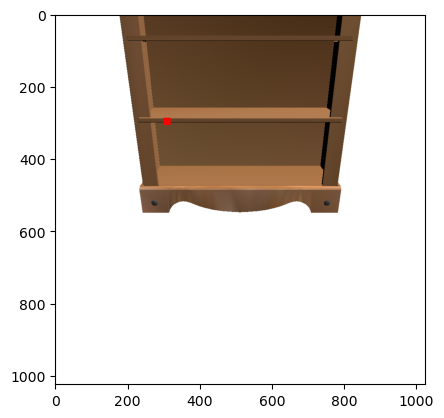

In [18]:
# elev = torch.deg2rad(torch.tensor(45)).to(device)
# azim = torch.deg2rad(torch.tensor(25)).to(device)
elev = torch.deg2rad(torch.tensor(25)).to(device)
azim = torch.deg2rad(torch.tensor(90)).to(device)
# r = 1.3
r = 1.5
eye, look_at, up, right = get_camera_properties(elev, azim, r)
print(f'Camera parameters: {eye, look_at, up}')
image, face_idx = render_view(elev, azim, r)
face_idx = face_idx.squeeze()
# pixel = (650, 570)
pixel = (297, 310)
face_id = face_idx[pixel[0], pixel[1]].item()
p = mp.plot(point_cloud, shading={'point_size':0.1, 'point_color':'black'}, return_plot=True)
# p.add_mesh(vertices, faces)

pt = project_pixel(pixel, torch.tensor(point_cloud, 
                device=torch.device('cuda:0'),
                dtype=torch.float32), 1024, 1024, eye, up, look_at, right, np.pi/3., face_id)
print(f'pt: {pt}')
image[pixel[0]-10:pixel[0]+10, pixel[1]-10:pixel[1]+10] = np.array([255,0,0])
plt.imshow(image)
plt.show()
p.add_points(point_cloud[pt].reshape(1, -1), shading={'point_size':0.35, 'point_color':'blue'})
plt.show()

In [23]:
def project_back_image(bbox, width, height, point_cloud, elev, azim, r, fov, face_idx, p):
    (startX, startY) , (endX, endY) = (bbox[0], bbox[1])
    pts_colors = np.zeros((point_cloud.shape[0], 3))
    eye, look_at, up, right = get_camera_properties(elev, azim, r)
    torchPC = torch.tensor(point_cloud, device=torch.device('cuda:0'), dtype=torch.float32)
    for row in range(startY, endY):
        for col in range(startX, endX):
            pixel = (row, col)
            face_id = face_idx[row, col].item()
            pt = project_pixel(pixel, torchPC, width, height, eye, up, look_at, right, fov, face_id)
            if (point_cloud[pt, 0] > 0):
                print(f'Outlier: {row, col}, pt={pt}')
            pts_colors[pt] = np.array([255,0,0])      
    return pts_colors

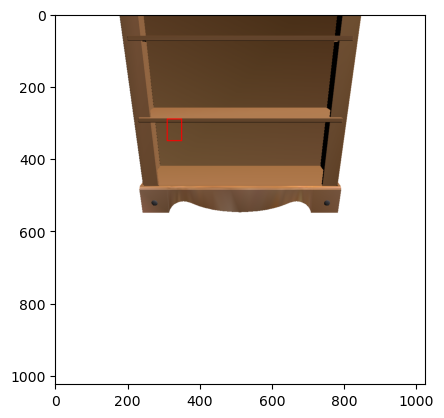

In [30]:
elev = torch.deg2rad(torch.tensor(25)).to(device)
azim = torch.deg2rad(torch.tensor(90)).to(device)
r = 1.5
fov = np.pi / 3.
image, face_idx = render_view(elev, azim, r)
face_idx = face_idx.squeeze().cpu().numpy()
img_to_show = image.copy()
startX = 310; startY = 290; endX = 350; endY = 350
bb = [(startX, startY), (endX, endY)]
cv2.rectangle(img_to_show, (startX, startY), (endX, endY), [255,0,0], 2)
plt.imshow(img_to_show)
plt.show()

In [31]:
colors = project_back_image(bb, 1024, 1024,point_cloud, elev, azim, r, fov, face_idx, p)
p = mp.plot(point_cloud, c = colors, shading = {'point_size':0.18}, return_plot=True)
plt.show()

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.4272670…

In [ ]:
def project_naive(face_idx, point_cloud, bb):
    (startX, startY) , (endX, endY) = (bb[0], bb[1])
    pts_colors = np.zeros((point_cloud.shape[0], 3))
    included_faces = np.unique(face_idx[startY:endY, startX:endX])
    for face_id in included_faces:
        pt_lst = face_to_all_pts[face_id.item()]
        for i in range(len(pt_lst)):
            pt = pt_lst[i]
            pts_colors[pt] = np.array([1,0,0])
    return pts_colors

In [ ]:
elev = torch.deg2rad(torch.tensor(15)).to(device)
azim = torch.deg2rad(torch.tensor(270)).to(device)
r = 2.
fov = np.pi / 3.
image, face_idx = render_view(elev, azim, r)
face_idx = face_idx.squeeze().cpu().numpy()
img_to_show = image.copy()
startX = 300; startY = 120; endX = 720; endY = 600
bb = [(startX, startY), (endX, endY)]
cv2.rectangle(img_to_show, (startX, startY), (endX, endY), [255,0,0], 2)
plt.imshow(img_to_show)
plt.show()

In [ ]:
elev = torch.deg2rad(torch.tensor(15)).to(device)
azim = torch.deg2rad(torch.tensor(70)).to(device)
image, face_idx = render_view(elev, azim, 2)
face_idx = face_idx.squeeze().cpu().numpy()
img_to_show = image.copy()
startX = 310; startY = 550; endX = 720; endY = 600
bb = [(startX, startY), (endX, endY)]
cv2.rectangle(img_to_show, (startX, startY), (endX, endY), [255,0,0], 2)
plt.imshow(img_to_show)
plt.show()

In [ ]:
mp.plot(point_cloud, c = project_naive(face_idx, point_cloud, bb), shading = {'point_size':0.1})
plt.show()

In [ ]:
elev = torch.deg2rad(torch.tensor(40)).to(device)
azim = torch.deg2rad(torch.tensor(130)).to(device)
image, face_idx = render_view(elev, azim, 2)
face_idx = face_idx.squeeze().cpu().numpy()
img_to_show = image.copy()
startX = 250; startY = 150; endX = 720; endY = 640
bb = [(startX, startY), (endX, endY)]
cv2.rectangle(img_to_show, (startX, startY), (endX, endY), [255,0,0], 2)
plt.imshow(img_to_show)
plt.show()

In [ ]:
mp.plot(point_cloud, c = project_naive(face_idx, point_cloud, bb), shading = {'point_size':0.1})
plt.show()